In [21]:
# Plot outputs from application
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import _LRScheduler

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix, accuracy_score
import sys
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '../..')))

from Lamp.AttrDict.AttrDict import *
from Lamp.Model.Dataloader import *
from Lamp.Model.BaseModel import *
from Lamp.Model.ResNet import ResNet as ResNet, BasicBlock
from Lamp.Model.Baseline import Net as Baseline

In [22]:
def load_config(cfg_path):
    """  """
    if os.path.splitext(cfg_path)[-1] == '.json':
        return AttrDict.from_json_path(cfg_path)
    elif os.path.splitext(cfg_path)[-1] in ['.yaml', '.yml']:
        return AttrDict.from_yaml_path(cfg_path)
    else:
        raise ValueError(f"Unsupported config file format. Only '.json', '.yaml' and '.yml' files are supported.")

class Classifier(BaseModelSingle):
    def __init__(self, net: nn.Module, opt: Optimizer = None, sched: _LRScheduler = None, 
        logger: Logger = None, print_progress: bool = True, device: str = 'cuda:0', **kwargs):
        super().__init__(net, opt=opt, sched=sched, logger=logger, print_progress=print_progress, device=device, **kwargs)

    def forward_loss(self, data: Tuple[Tensor]) -> Tensor:
        """  """
        pass

    def predict(self, loader):
        """  """
        labels = []
        self.net.eval()
        with torch.no_grad():
            for b, data in enumerate(loader):
                input, label = data
                input = input.to(self.device)
                label = label.to(self.device).long()

                output = self.net(input)
                pred = torch.argmax(output, dim=1)

                labels += list(zip(pred.cpu().data.tolist(), label.cpu().data.tolist()))

            pred, label = zip(*labels)
        #acc = accuracy_score(np.array(label), np.array(pred))

        return pred, label

dict_transform = {
    "Padding":Padding,
    "VerticalFlip":tf.RandomVerticalFlip,
    "HorizontalFlip":tf.RandomHorizontalFlip,
    "Rotation":tf.RandomRotation,
    "CenterCrop":tf.CenterCrop,
    "Resize":tf.Resize,
}

def resnet(layers=[3, 4, 6, 3],channels=3, num_classes=1000):
    model = ResNet(BasicBlock,layers,channels=channels,num_classes=num_classes)
    return model

In [23]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
print(torch.cuda.get_device_name(device))

cuda:0
NVIDIA GeForce 940MX


In [24]:
df_preds = pd.read_csv('../Application/comparison_data.csv',index_col=0)

# Pred Best Model
inputs = load_config("../Models/config/MAR_RESNET18_PADDED_256_ALL_NEW.yaml")

root_path = os.path.abspath(os.path.join(os.getcwd(), '..')) # Workspace path to Cuttings_Characterisation 
path_model = f"{root_path}/{inputs.PathSave}/{inputs.ModelName}"
model_name = f"model_all.pt"
save_model_path = f"{path_model}/{model_name}"

net = resnet(layers=inputs.Model.Layers,channels=inputs.Model.Channels,num_classes=inputs.Model.OutClasses)
best_model = Classifier(net=net,device=device)
best_model.load(save_model_path)

transforms_test = Transforms(
    [dict_transform[key]([k for k in item.values()] if len(item.values()) > 1 else [k for k in item.values()][0]) for key, item in inputs.TransformTest.items()] 
    )

testDataset = Dataset(
    df_preds.reset_index(drop=True),
    transforms=transforms_test.get_transforms()
    )

test_dataloader = torch.utils.data.DataLoader(
    testDataset, 
    batch_size=4,
    shuffle=False
    )
    
time_start = time.time()
pred, label = best_model.predict(test_dataloader)
time_end = time.time()

df_preds['best_model'] = pred

# Pred Baseline
inputs = load_config("../Baseline/config/MAR_BASELINE_PADDED_256_ALL_NEW.yaml")

root_path = os.path.abspath(os.path.join(os.getcwd(), '..')) # Workspace path to Cuttings_Characterisation 
path_model = f"{root_path}/{inputs.PathSave}/{inputs.ModelName}"
model_name = f"model_all.pt"
save_model_path = f"{path_model}/{model_name}"

net = Baseline()
baseline = Classifier(net=net,device=device)
baseline.load(save_model_path)

transforms_test = Transforms(
    [dict_transform[key]([k for k in item.values()] if len(item.values()) > 1 else [k for k in item.values()][0]) for key, item in inputs.TransformTest.items()] 
    )

testDataset = Dataset(
    df_preds.reset_index(drop=True),
    transforms=transforms_test.get_transforms()
    )

test_dataloader = torch.utils.data.DataLoader(
    testDataset, 
    batch_size=4,
    shuffle=False
    )

pred, label = baseline.predict(test_dataloader)

df_preds['baseline_model'] = pred

In [25]:
df_preds

,Paths,Label,best_model,baseline_model,PADDED_256_08121352,PADDED_256_time_08121352,RESIZED_256_08121358,RESIZED_256_time_08121358,MAR_RESNET34_PADDED_256_ALL_best_model,MAR_RESNET34_PADDED_256_ALL_baseline_model,CROPPED_256_08121900,CROPPED_256_time_08121900,PADDED_256_20121814,PADDED_256_time_20121814,PADDED_256_24120946,PADDED_256_time_24120946
0,../Data/Train/BL3-1-DL\slice01340 (2020_05_17 ...,0,0,0,0.0,4.60,0.0,4.09,0,0,4.0,2.35,4.0,15.49,0.0,1.33
1,../Data/Train/BL3-1-DL\slice00670 (2020_05_17 ...,0,0,2,0.0,6.07,0.0,4.17,0,0,0.0,1.93,0.0,1.93,0.0,1.52
2,../Data/Train/BL3-4-DL\slice01180 (2020_05_17 ...,0,4,4,0.0,1.88,4.0,7.59,0,0,4.0,17.78,0.0,2.32,0.0,1.57
3,../Data/Train/BL3-4-DL\slice01140 (2020_05_17 ...,0,0,0,0.0,1.45,0.0,1.27,0,0,4.0,2.14,0.0,2.07,0.0,1.12
4,../Data/Train/BL3-4-DL\slice01140 (2020_05_17 ...,0,0,0,0.0,1.39,0.0,1.12,0,0,0.0,8.88,0.0,2.18,0.0,1.88
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,../Data/Train/OL4-3-DL\slice01090 (2020_05_17 ...,4,4,4,4.0,1.56,4.0,1.58,4,4,0.0,1.97,4.0,4.20,4.0,0.91
96,../Data/Train/OL7-3-DL\slice00370 (2020_05_17 ...,4,4,4,2.0,1.54,4.0,2.18,4,4,4.0,2.71,4.0,3.57,4.0,1.57
97,../Data/Train/OL-7-1-DL\slice00270 (2020_05_17...,4,4,4,4.0,3.55,4.0,1.86,4,4,0.0,1.98,4.0,3.20,4.0,1.54
98,../Data/Train/OL-7-1-DL\slice00600 (2020_05_17...,4,4,4,2.0,1.19,2.0,2.82,4,4,2.0,2.77,4.0,1.94,2.0,1.42


In [46]:
np.asarray(acc_user).mean(axis=0)
np.asarray(acc_user).min(axis=0)
np.asarray(acc_user).max(axis=0)

yerr = np.array((np.asarray(acc_user).mean(axis=0) - np.asarray(acc_user).min(axis=0),np.asarray(acc_user).max(axis=0) - np.asarray(acc_user).mean(axis=0)))

In [47]:
yerr

array([[0.1       , 0.03333333, 0.08333333, 0.        , 0.1       ],
       [0.05      , 0.01666667, 0.11666667, 0.        , 0.1       ]])

[0.95 1.   1.   1.   0.95]
[0.85 1.   1.   1.   0.85]
[array([1.  , 0.95, 0.95, 1.  , 0.75]), array([0.85, 1.  , 0.75, 1.  , 0.95]), array([1.  , 1.  , 0.8 , 1.  , 0.85])]


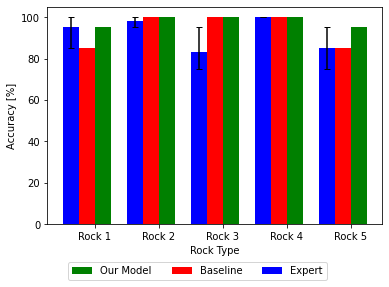

In [51]:
matrix = confusion_matrix(df_preds['Label'], df_preds['best_model'])
our_model_vec = matrix.diagonal()/matrix.sum(axis=1)
print(our_model_vec)
matrix = confusion_matrix(df_preds['Label'], df_preds['baseline_model'])
baseline_vec = matrix.diagonal()/matrix.sum(axis=1)
print(baseline_vec)

acc_user = []
for app_test in ['PADDED_256_08121352','PADDED_256_20121814','PADDED_256_24120946']:
    matrix = confusion_matrix(df_preds['Label'], df_preds[app_test])
    acc_user.append(matrix.diagonal()/matrix.sum(axis=1))

print(acc_user)
n = 5
fig, ax = plt.subplots()
index = np.arange(n)
bar_width = 0.25
ax.bar(index+bar_width, np.array(our_model_vec)*100, bar_width, color='g',
                label='Our Model')
ax.bar(index, np.array(baseline_vec)*100, bar_width, color='r',
                label='Baseline')
ax.bar(index-bar_width, np.asarray(acc_user).mean(axis=0) *100, bar_width, yerr=yerr*100,color='b',capsize=3,
                label='Expert')
ax.set_xlabel('Rock Type')
ax.set_ylabel('Accuracy [%]')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(('Rock 1','Rock 2','Rock 3','Rock 4','Rock 5'))
ax.legend(bbox_to_anchor=(0.85,-0.15),ncol=3)
plt.savefig('../FiguresPaper/model_comparison.png',bbox_inches='tight')

In [54]:
# Accuracies :

# Expert
acc_vec = []
for app_test in ['PADDED_256_08121352','PADDED_256_20121814','PADDED_256_24120946']:
    acc_vec.append(accuracy_score(df_preds['Label'], df_preds[app_test]))

print(f"Mean Acc Expert : {np.mean(np.array(acc_vec))}")
# Baseline
print(f"Acc Baseline : {accuracy_score(df_preds['Label'], df_preds['baseline_model'])}")
# Model 
print(f"Acc Best Model : {accuracy_score(df_preds['Label'], df_preds['best_model'])}")


Mean Acc Expert : 0.9233333333333333
Acc Baseline : 0.94
Acc Best Model : 0.98


In [59]:
df_preds['PADDED_256_time_24120946'].sum()

203.98

In [17]:
time_end - time_start

1.6656465530395508

In [60]:
203.98/1.6656465530395508

122.46295567794238